# Motivation of using GINI Initialization 

Experiments on 4 datasets：
* Two Synthetic datasets that we know the ground truth
* Two Realworld datasets we insert Noise

---
Madelon

In [15]:
from scipy.io import loadmat
from scipy.sparse import issparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
mat = loadmat("Data/madelon.mat")
X = mat["X"]
y = mat["Y"]
if issparse(X):
    X = X.todense()
y = y.flatten()
y[np.where(y == -1)] = 0
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X.shape, y.shape)

(2600, 500) (2600,)


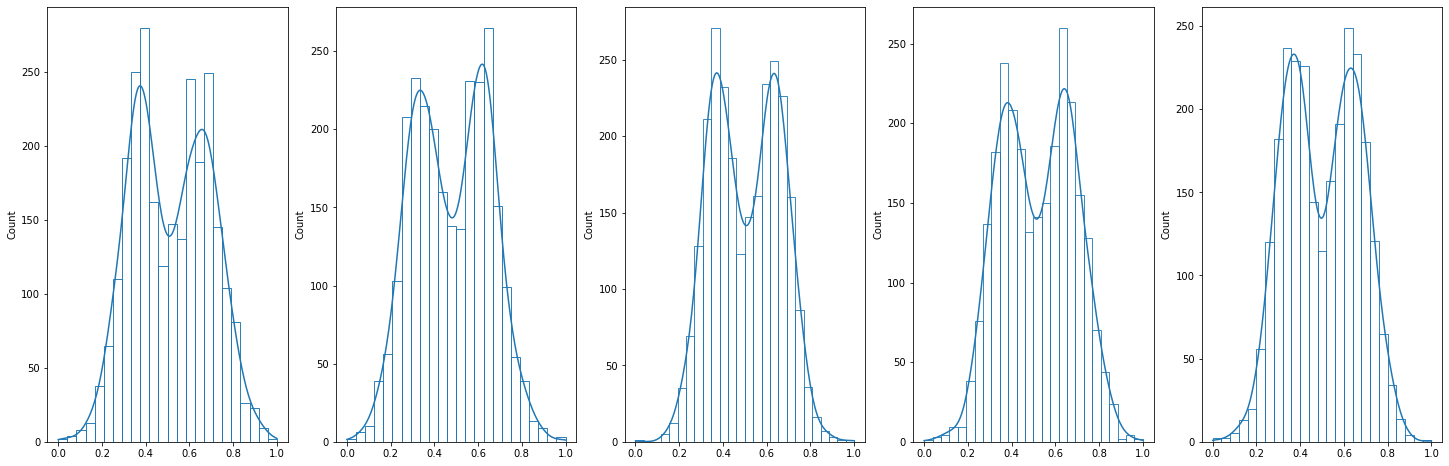

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 8))
for i, base_feature_idx in enumerate([28, 48, 153, 241, 455]):
  sns.histplot(X[:, base_feature_idx], ax=axs[i], kde=True, fill=False)
plt.show()

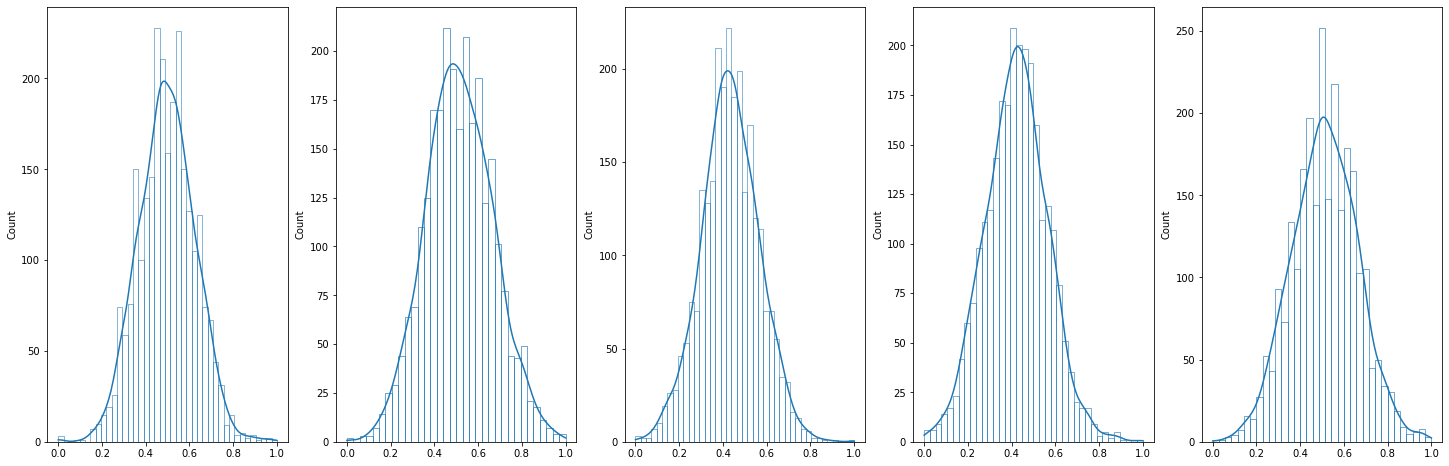

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 8))
for i, feature_idx in enumerate(np.random.choice(list(range(0, 500)), 5)):
  sns.histplot(X[:, feature_idx], ax=axs[i], kde=True, fill=False)
plt.show()

In [18]:
correct_label = np.zeros(X.shape[1])
correct_label[[28, 48, 153, 241, 455]] = 1
print(np.count_nonzero(correct_label))

5


Can gini filter find the noisy feature

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
from Gini import gini_score_fast_old
from sklearn.metrics import f1_score
import torch
accs = []
percentages = []
X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.long)
g_score = gini_score_fast_old(X, y)
for percentage in [5] + list(np.arange(0.1, 1, 0.05)):
    index = np.argsort(g_score)
    if isinstance(percentage, float):
        index_left = index[:int(percentage*len(index))]
    else:
        index_left = index[:percentage]
        percentage = 0
        print(index_left)
    pred_label = np.zeros_like(correct_label)
    pred_label[index_left] = 1
    percentages.append(percentage)
    acc = accuracy_score(correct_label, pred_label)
    accs.append(acc)
    #print(acc, percentage)

tensor([241, 338, 475, 128, 105])


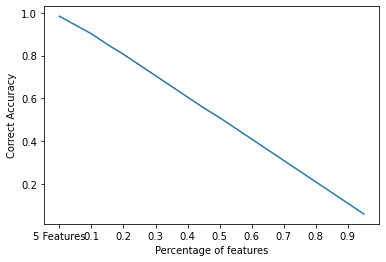

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(percentages, accs)
plt.xlabel('Percentage of features')
plt.ylabel('Correct Accuracy')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "5 Features"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels)
plt.show()

---
SFFS

In [22]:
X = X.numpy()
y = y.numpy()

In [23]:
from SFFS import get_f_stat_index
index = get_f_stat_index(X, y)
sffs_accs = []
for percentage in [5] + list(np.arange(0.1, 1, 0.05)):
    index = np.argsort(g_score)
    if isinstance(percentage, float):
        index_left = index[:int(percentage*len(index))]
    else:
        index_left = index[:percentage]
        percentage = 0
    pred_label = np.zeros_like(correct_label)
    pred_label[index_left] = 1
    acc = accuracy_score(correct_label, pred_label)
    sffs_accs.append(acc)

total computation time for pinv is: 0.03791022300720215


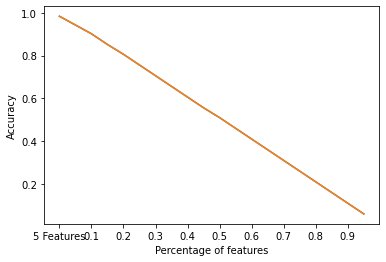

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
plt.xlabel('Percentage of features')
plt.ylabel('Accuracy')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "5 Features"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels)
ax.plot(percentages, accs)
ax.plot(percentages, sffs_accs)
plt.show()

In [25]:
from Data import VFLDataset
dataset = VFLDataset(data_source=(X, y), 
                    num_clients=1,
                    insert_noise=False)

Client 0: Feature Index 0-249
Server : Feature Index 250-499


In [30]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset.train(), batch_size=128, shuffle=True)
val_loader = DataLoader(dataset.valid(), batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset.test(), batch_size=1000, shuffle=True)

In [71]:
import VFL
gini_stg_accs = {
    'percentage': [],
    'acc': [],
}
stg_percentages = [5] +list(np.arange(0.1, 1, 0.1))
for _ in range(3):
    for percentage in stg_percentages:
        if percentage == 5:
            percentage = 0
        gini_labels = dataset.gini_filter(percentage)
        feat_idx_list = dataset.get_feature_index_list()
        input_dim_list = dataset.get_input_dim_list()
        mus = VFL.initialize_mu(gini_labels, feat_idx_list)
        models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=64,
                            output_dim=2, hidden_dims=[256, 256],
                            activation='relu', mus=mus, lam=0.1)
        VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=40, lr=0.01, optimizer='Adam',verbose=False, save_mask_at=10000, 
                criterion=torch.nn.CrossEntropyLoss())
        z_list = []
        for model in models:
            z, num_feat = model.get_gates()
            z_list.append(z)
        z_pred = np.concatenate(z_list)
        z_pred = z_pred >= 1e-5
        # print(np.nonzero(z_pred))
        # print(np.nonzero(correct_label))
        acc = accuracy_score(correct_label, z_pred)
        print(percentage, acc)
        gini_stg_accs['acc'].append(acc)
        gini_stg_accs['percentage'].append(percentage)

0
0 0.99
0.1 0.964
0.2 0.914
0.30000000000000004 0.908
0.4 0.99
0.5 0.87
0.6 0.89
0.7000000000000001 0.926
0.8 0.832
0.9 0.868
0
0 0.986
0.1 0.96
0.2 0.978
0.30000000000000004 0.846
0.4 0.93
0.5 0.982
0.6 0.788
0.7000000000000001 0.962
0.8 0.8
0.9 0.558
0
0 0.99
0.1 0.982
0.2 0.91
0.30000000000000004 0.984
0.4 0.976
0.5 0.988
0.6 0.648
0.7000000000000001 0.952
0.8 0.99
0.9 0.644


In [80]:
import VFL
stg_accs = {
    'percentage': [],
    'acc': [],
}
stg_percentages = [5] +list(np.arange(0.1, 1, 0.1))
for _ in range(3):
    for percentage in stg_percentages:
        if percentage == 5:
            percentage = 0
        # gini_labels = dataset.gini_filter(percentage)
        # feat_idx_list = dataset.get_feature_index_list()
        input_dim_list = dataset.get_input_dim_list()
        # mus = VFL.initialize_mu(gini_labels, feat_idx_list)
        models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=64,
                            output_dim=2, hidden_dims=[256, 256],
                            activation='relu', mus=mus, lam=0.1)
        VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=40, lr=0.01, optimizer='Adam',verbose=False, save_mask_at=10000, 
                criterion=torch.nn.CrossEntropyLoss())
        z_list = []
        for model in models:
            z, num_feat = model.get_gates()
            z_list.append(z)
        z_pred = np.concatenate(z_list)
        z_pred = z_pred >= 1e-5
        # print(np.nonzero(z_pred))
        # print(np.nonzero(correct_label))
        acc = accuracy_score(correct_label, z_pred)
        print(percentage, acc)
        stg_accs['acc'].append(acc)
        stg_accs['percentage'].append(percentage)

0 0.916
0.1 0.922
0.2 0.934
0.30000000000000004 0.764
0.4 0.634
0.5 0.838
0.6 0.748
0.7000000000000001 0.786
0.8 0.962
0.9 0.946
0 0.796
0.1 0.762
0.2 0.774
0.30000000000000004 0.696
0.4 0.99
0.5 0.786
0.6 0.752
0.7000000000000001 0.756
0.8 0.694
0.9 0.892
0 0.506
0.1 0.79
0.2 0.592
0.30000000000000004 0.844
0.4 0.968
0.5 0.596
0.6 0.784
0.7000000000000001 0.892
0.8 0.758
0.9 0.974


---
To reproduce and replot the figure


In [ ]:
import dill 
dill.load_session('gini_stg_motivation.db')

---


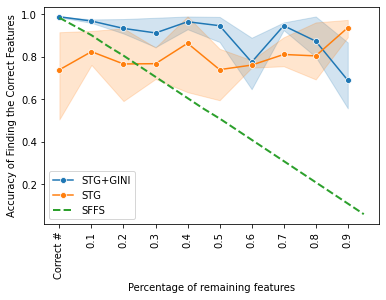

In [83]:
import pandas as pd
fig, ax = plt.subplots() 
plt.xlabel('Percentage of remaining features')
plt.ylabel('Accuracy of Finding the Correct Features')
sns.lineplot(data=pd.DataFrame(gini_stg_accs), x='percentage', y='acc',
   label="STG+GINI", marker='o')
sns.lineplot(data=pd.DataFrame(stg_accs), x='percentage', y='acc', 
    label="STG", marker='o')
ax.plot(percentages, sffs_accs, '--', linewidth=2, label='SFFS')
labels = [f'{tick:.1f}' for tick in np.arange(0, 1, 0.1)]
labels[0] = "Correct #"
plt.xticks(ticks=np.arange(0, 1, 0.1), labels=labels, rotation=90)
plt.legend()
plt.show()

In [84]:
import dill
dill.dump_session('gini_stg_motivation.db')